# MS-E2122 - Nonlinear Optimization
### Prof. Fabricio Oliveira

## Project Assignment 1

In [1]:
using ForwardDiff    
using LinearAlgebra
using BenchmarkTools
using Test 
using Plots
using LaTeXStrings 
pyplot() 

## Functions to compute gradient, hessian and first derivative
∇(f,x) = ForwardDiff.gradient(f, x);
H(f,x) = ForwardDiff.hessian(f, x);
d(θ,λ) = ForwardDiff.derivative(θ, λ)

const tol = 1e-3      # unconstrained method convergence tolerance
const tol_ls = 1e-7   # line search convergence tolerance

1.0e-7

## Exact line search : bisection method

We will implement below the method that will be exact line search in our unconstrained optimisation methods. 

Notice that all our function will have a list the keyword arguments (those occuring AFTER the semi-colon ';') that already have standard values assigned. Two things about those:
1. I (Fabricio) prefer to use keyword arguments because they are order independent (so you don't have to struggle with functions with arguments in the wrong order) and it makes it clear to the user what parameters are being set.
2. If a keyword argument has a standard parameter assigned, setting the value of that argument when calling the function is optional. For example, if we are happy with the standard values, the function below can be called as `bisection(\theta)`, without needing any further argument 

### Inputs: 
- θ: line search function
- a: initial lower bound
- b: initial upper bound

### Output:
- λ: step size

In [2]:
function bisection(θ; a=0.0, b=10.0, ϵ=tol_ls)

    λ, dθ = 0.0, 0.0
    
    while b - a > ϵ
        λ = (a + b)/2
        dθ= d(θ, λ)
        
        # TODO: implement the bisection method update
        if dθ == 0
            return λ
        elseif dθ > 0
            b = λ
        else
            a = λ
        end
    end
        return λ
end

bisection (generic function with 1 method)

## Testing the exact line search 

Notice we are using the same "test bed" from homework 2.

In [3]:
# Test functions
θ1(x) = 3x^2 -4x + 6           # Optimal value x = 2/3
θ2(x) = exp(x) - 10x^2 - 20x   # Optimal value x = 4.743864 (in [0,10])

@test abs(bisection(θ1) - 2/3) <= 1e-4
@test abs(bisection(θ2) - 4.743864) <= 1e-4

Test Passed

## Inexact line search : Armijo rule

### Inputs: 
- θ: line search function
- λ: initial step size value
- α: slope reduction factor
- β: λ reduction factor

### Output:
- λ: a step size value that satisfies the Armijo rule

In [3]:
function armijo(θ; λ=1.0, α=0.01, β=0.7) 
    
    θ₀  = θ(0)                 # Function value at zero (use \theta + tab and \_0 + tab to add the subscript to θ)
    dθ = d(θ, 0)               # Derivative (slope) at zero   
    
                               
    θλ = θ(λ)                  # value of function at point λ
    while θλ > θ₀ + α*λ*dθ     # Armijo criteterion check
        λ = β*λ                # decrease λ by predefined factor
        θλ = θ(λ)              # recompute value of function at point λ
    end
    return λ
end

armijo (generic function with 1 method)

## Testing the inexact line search 

Armijo returns pproximate values for the optimal. Notice for the second function we need to increase the initial step size.

In [5]:
# Test functions
θ1(x) = 3x^2 -4x + 6           # Optimal value x = 2/3
θ2(x) = exp(x) - 10x^2 - 20x   # Optimal value x = 4.743864 (in [0,10])

@test abs(armijo(θ1) - 1.0) <= 1e-4
@test abs(armijo(θ2, λ=20.0) - 4.802) <= 1e-4

Test Passed

## Gradient (descent) method

### Inputs
- f: function to minimize
- x_start: starting point
- max_steps: maximum number of iterations
- exact_ls: if `true`, the method uses the bisection line search; if `false`, it uses the Armijo rule 
- save_history: set `true` if you need the history of the iterations for analysing the trajectory.
- ϵ: convergence tolerance 

### Outputs
Either `(x_iter, k-1)` (if `save_history = true`) or `(f(x), k-1) `(if `save_history = false`)  
- x_iter: a matrix with n columns and as many rows as iterations with each point visited 
- f(x): function value at the point of convergence
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [4]:
function gradient(f; x_start=[0,0], max_steps=1000, exact_ls=true, save_history=false, ϵ=tol)
    
    # if we need to save the history of iterations 
    if save_history 
        x_iter = zeros(max_steps, length(x_start))
    end 
    
    x = x_start               # initial x should be set to x_start 
    for k = 1:max_steps                
        ∇f = ∇(f, x)          # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient        
        
        if norm∇f < ϵ         # Stopping condition #1           
            if save_history
                x_iter = vcat(x_start', x_iter)    # Including starting point
                return (x_iter[1:k, :], k-1)       # Return the history of points, iterations            
            else
                return (f(x), k-1)                 # Return cost and iterations            
            end                    
        end
        
        # TODO: set the Gradient Descent direction d (don't forget the normalisation)
        d = -∇f/norm∇f                            # set the Gradient Descent direction d with the normalisation

        
        # TODO: define the line search function θ
        θ(λ) = f(x + λ*d)                         # define the line search function θ

        if exact_ls
            λ = bisection(θ)                     # Calls Golden Section method to compute optimal step size λ                         
        else     
            λ = armijo(θ)                        # Calls Armijo method to compute optimal step size λ  
        end
       
        # TODO: Update the solution x at this iteration accordingly
        x = x + λ*d                             # Update the solution x at this iteration accordingly
        
        if save_history 
            x_iter[k, :] = x                   # save the history if needed
        end    
    end
    
    if save_history
        x_iter = vcat(x_start', x_iter)    # Including starting point
        return (x_iter, max_steps)         # Return the history of cost, iterations
    else    
        return (f(x), max_steps)           # Return last cost, iterations count 
    end
    
end

gradient (generic function with 1 method)

## Testing the gradient method

In [7]:
# Function fot the test 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      
 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202
(xg, kg) = gradient(f, x_start = x, exact_ls = true, save_history = true)

@test abs(f(xg[end,:]) - 2.3157202) <= 1e-4
@test norm(xg[end,:]) <= 1e04

Test Passed

## Measuring performance

Julia offers the macro `@time` for measuring time, but it is more robust to use `@benchmark` and `@btime` from the package `BenchmarkTools`. In the former the funcion is executed multiple times and average values are reported.

Notice that Julia uses something called just-in-time compilation. That roughly means that the first time you run a new function, there is a extra time for the code to be compiled. The macro `@time` informs the amount of time used in compilation, while `@btime` discard this measurement with compilation time.

In [8]:
#Obtaining time statistics using @benchmark
@benchmark gradient(f, x_start = x, exact_ls = true)    # Gradient method with exact line search

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  121.519 μs …   9.186 ms  ┊ GC (min … max): 0.00% … 96.82%
 Time  (median):     126.947 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   154.649 μs ± 230.934 μs  ┊ GC (mean ± σ):  4.76% ±  3.19%

  ▅█▆▃▄▄▃▃▂▂ ▁▁▂▂▂▂▁▁                  ▁   ▁▁▂▁▁▁▁▁             ▁
  ████████████████████▇▆▇▇▇▇▇▅▆▆▇▆▆▆▇▇████████████████▇▇▇▆▆▅▆▆▆ █
  122 μs        Histogram: log(frequency) by time        270 μs <

 Memory estimate: 50.62 KiB, allocs estimate: 893.

In [9]:
#Since we are only interested in the time, we can use @btime instead
print("Gradient method with exact line search:")
@btime gradient(f, x_start = x)    # Gradient method with exact line search

print("Gradient method with Armijo line search:")
@btime gradient(f, x_start = x, exact_ls = false)   # Gradient method with inexact line search

Gradient method with exact line search:  120.939 μs (893 allocations: 50.59 KiB)
Gradient method with Armijo line search:  143.688 μs (1763 allocations: 82.41 KiB)


(2.3157203731087854, 22)

In [10]:
# Or if we want to measure time once, we can use @time
print("Gradient method with exact line search:")
@time gradient(f, x_start = x)    # Gradient method with exact line search

print("Gradient method with Armijo line search:")
@time gradient(f, x_start = x, exact_ls = false)   # Gradient method with inexact line search

Gradient method with exact line search:  0.000184 seconds (893 allocations: 50.594 KiB)
Gradient method with Armijo line search:  0.000297 seconds (1.76 k allocations: 82.406 KiB)


(2.3157203731087854, 22)

## Heavy ball method

### Inputs
- f: function to minimize
- weight: Heavy ball weighting parameter
- x_start: starting point
- max_steps: maximum number of iterations
- exact_ls: if `true`, the method uses the bisection line search; if `false`, it uses the Armijo rule 
- save_history: set `true` if you need the history of the iterations for analysing the trajectory.
- ϵ: convergence tolerance 

### Outputs
Either `(x_iter, k-1)` (if `save_history = true`) or `(f(x), k-1) `(if `save_history = false`)  
- x_iter: a matrix with n columns and as many rows as iterations with each point visited 
- f(x): function value at the point of convergence
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [5]:
function heavy_ball(f; weight=0.5, x_start=[0,0], max_steps=1000, exact_ls=true, save_history=false, ϵ=tol)
    
    # If we need to save the history of iterations 
    if save_history 
        x_iter = zeros(max_steps, length(x_start))
    end 
    
    d = zeros(size(x_start))  # Placeholder for direction d
    
    x = x_start               # Initial x should be set to x_start 
    for k = 1:max_steps                
        ∇f = ∇(f, x)          # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient        
        
        if norm∇f < ϵ         # Stopping condition #1           
            if save_history
                x_iter = vcat(x_start', x_iter)       # Including starting point
                return (x_iter[1:k, :], k-1)        # Return the history of points, iterations            
            else
                return (f(x), k-1)                    # Return cost and iterations            
            end                    
        end     
        
        # TODO: set the Heavy ball direction d
        d = -(1 - weight) * ∇f / norm∇f + weight * d  # set the Gradient Descent direction d with the normalisation
        
        # TODO: define the line search function θ
        θ(λ) = f(x + λ*d)                             # define the line search function θ

        if exact_ls
            λ = bisection(θ)    # Calls Golden Section method to compute optimal step size λ                         
        else     
            λ = armijo(θ)       # Calls Armijo method to compute optimal step size λ  
        end
              
        # TODO: Update the solution x at this iteration accordingly
        x =  x + λ*d
        
        if save_history 
            x_iter[k, :] = x    # save the history if needed
        end 
    end
    
    if save_history
        x_iter = vcat(x_start', x_iter)    # Including starting point
        return (x_iter, max_steps)  # Return the history of cost, iterations
    else    
        return (f(x), max_steps)    # Return last cost, iterations count 
    end

end

heavy_ball (generic function with 1 method)

## Testing the heavy ball method

In [12]:
# Function fot the test 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      
 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202
(xh, kh) = heavy_ball(f, x_start = x, exact_ls = true, save_history = true)

@test abs(f(xh[end,:]) - 2.3157202) <= 1e-4
@test norm(xh[end,:]) <= 1e04

Test Passed

## Time stats for heavy ball method

In [13]:
#Obtaining time statistics using @btime 
print("Heavy ball method with exact line search (default weight = 0.7):")
@btime heavy_ball(f, x_start = x)                  # Heavy ball method with exact line search

print("Heavy ball method with exact line search and weight = 0.3:")
@btime heavy_ball(f, weight = 0.3, x_start = x)    # Heavy ball method with exact line search and different weight

print("Heavy ball method with inexact line search and default weight:")
@btime heavy_ball(f, x_start = x, exact_ls = false)                 # Heavy ball method with inexact line search

# SPLIT

#Obtaining time statistics using @benchmark
@benchmark heavy_ball(f, x_start = x, exact_ls = true)    # Heavy ball method with exact line search

Heavy ball method with exact line search (default weight = 0.7):  238.507 μs (2149 allocations: 113.61 KiB)
Heavy ball method with exact line search and weight = 0.3:  159.767 μs (1438 allocations: 75.97 KiB)
Heavy ball method with inexact line search and default weight:  135.071 μs (1664 allocations: 76.42 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  239.601 μs …   8.188 ms  ┊ GC (min … max): 0.00% … 95.70%
 Time  (median):     245.818 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   268.643 μs ± 358.499 μs  ┊ GC (mean ± σ):  6.31% ±  4.58%

   ▂▆██▇▆▄▃▃▂▂▂▂▁▁▁                                             ▂
  ▄███████████████████▇▇▆▆▆▆▆▅▅▆▇▇████▇▇▇▅▆▅▄▄▄▆▇▇█████▇▇▆▆▅▄▆▆ █
  240 μs        Histogram: log(frequency) by time        319 μs <

 Memory estimate: 113.64 KiB, allocs estimate: 2149.

## Newton's method

### Inputs
- f: function to minimize
- x_start: starting point
- max_steps: maximum number of iterations
- exact_ls: if `true`, the method uses the bisection line search; if `false`, it uses the Armijo rule 
- save_history: set `true` if you need the history of the iterations for analysing the trajectory.
- ϵ: convergence tolerance 

### Outputs
Either `(x_iter, k-1)` (if `save_history = true`) or `(f(x), k-1) `(if `save_history = false`)  
- x_iter: a matrix with n columns and as many rows as iterations with each point visited 
- f(x): function value at the point of convergence
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [6]:
function newton(f; x_start=[0,0], max_steps=1000, exact_ls=true, save_history=false, ϵ=tol) 
    
    # if we need to save the history of iterations 
    if save_history 
        x_iter = zeros(max_steps, length(x_start))
    end 
    
    x = x_start               # initial x should be set to x_start 
    for k = 1:max_steps                
        ∇f = ∇(f, x)          # Gradient at iteration k  
        norm∇f = norm(∇f)     # Norm of the gradient        
    
        if norm∇f < ϵ         # Stopping condition #1           
            if save_history
                x_iter = vcat(x_start', x_iter)    # Including starting point
                return (x_iter[1:k, :], k-1)       # Return the history of points, iterations            
            else
                return (f(x), k-1)                 # Return cost and iterations            
            end                    
        end     
        
        # TODO: set the Newton's method direction d (remeber that backslash '\' is more efficient than inv())
        d = -H(f,x)\∇f
        
        # TODO: define the line search function θ
        θ(λ) = f(x + λ*d)                             # define the line search function θ

        if exact_ls
            λ = bisection(θ)    # Calls Golden Section method to compute optimal step size λ                         
        else     
            λ = armijo(θ)       # Calls Armijo method to compute optimal step size λ  
        end
       
        # TODO: Update the solution x at this iteration accordingly
        x = x + λ*d             # Update solution
        
        if save_history 
            x_iter[k, :] = x    # save the history if needed
        end 
    end
    
    if save_history
        x_iter = vcat(x_start', x_iter)    # Including starting point
        return (x_iter, max_steps)  # Return the history of cost, iterations
    else    
        return (f(x), max_steps)    # Return last cost, iterations count 
    end      
end

newton (generic function with 1 method)

## Tests for the Newton's method

In [15]:
# Function for the tests 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      
 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202
(xn, kn) = newton(f, x_start = x, exact_ls = true, save_history = true)

@test abs(f(xn[end,:]) - 2.3157202) <= 1e-4
@test norm(xn[end,:]) <= 1e04

Test Passed

## Time stats for the Newton's method

In [16]:
#Obtaining time statistics using @btime 
print("Newton with exact line search:")
@btime newton(f, x_start = x)

print("Newton with inexact line search:")
@btime newton(f, x_start = x, exact_ls = false)

# SPLIT

#Obtaining time statistics using @benchmark
@benchmark newton(f, x_start = x, exact_ls = true)    # newton method with exact line search

Newton with exact line search:  105.136 μs (643 allocations: 39.31 KiB)
Newton with inexact line search:  54.070 μs (239 allocations: 17.81 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  102.350 μs …   7.172 ms  ┊ GC (min … max): 0.00% … 96.78%
 Time  (median):     106.826 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   117.327 μs ± 196.421 μs  ┊ GC (mean ± σ):  4.64% ±  2.74%

  ▃▇█▇▅▃▂▂▂▂▁▁ ▂▂▃▃▃▂▂▂▂▂                                       ▂
  ████████████████████████▆▆▆▅▇▇▆▅▅▄▅▅▁▅▃▄▆▄▅▃▃▃▁▁▁▃▁▄▄▄▁▁▃▄▄▄▅ █
  102 μs        Histogram: log(frequency) by time        196 μs <

 Memory estimate: 39.34 KiB, allocs estimate: 643.

## Broyden–Fletcher–Goldfarb–Shanno (BFGS) method 


### Inputs
- f: function to minimize
- x_start: starting point
- max_steps: maximum number of iterations
- exact_ls: if `true`, the method uses the bisection line search; if `false`, it uses the Armijo rule 
- save_history: set `true` if you need the history of the iterations for analysing the trajectory.
- ϵ: convergence tolerance 

### Outputs
Either `(x_iter, k-1)` (if `save_history = true`) or `(f(x), k-1) `(if `save_history = false`)  
- x_iter: a matrix with n columns and as many rows as iterations with each point visited 
- f(x): function value at the point of convergence
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [7]:
function bfgs(f; x_start=[0,0], max_steps=1000, exact_ls=true, save_history=false, ϵ=tol) 
    
    # if we need to save the history of iterations 
    if save_history 
        x_iter = zeros(max_steps, length(x_start))
    end 
    
    n = length(x_start)                            # Number of variables in the problem
    B  = I(n)                                      # Initial Hessian approximation is the identity

    x = x_start                                    # initial x should be set to x_start 
    for k = 1:max_steps                
        ∇f = ∇(f, x)                              # Gradient at iteration k  
        norm∇f = norm(∇f)                         # Norm of the gradient        

        if norm∇f < ϵ                              # Stopping condition #1           
            if save_history
                x_iter = vcat(x_start', x_iter)    # Including starting point
                return (x_iter[1:k, :], k-1)       # Return the history of points, iterations            
            else
                return (f(x), k-1)                 # Return cost and iterations            
            end                    
        end
        
        # TODO: set the BFGS method direction d. Be consistent wiht the update used, 
        # that is, either the matrix B or its inverse. The latter doesn not require any backslash `/`
        # or inv() - do not use inv() though, for the same reason as in the Newton's method. 
        d = -B\∇f



        # TODO: define the line search function θ
        θ(λ) = f(x + λ*d)                            # define the line search function θ

        if exact_ls
            λ = bisection(θ)                         # Calls Golden Section method to compute optimal step size λ                         
        else     
            λ = armijo(θ)                            # Calls Armijo method to compute optimal step size λ  
        end 
        
        p = λ * d                                    # p = step size * direction
       
        # TODO: Update the solution x at this iteration accordingly
        x += p
        
        if save_history 
            x_iter[k, :] = x    # save the history if needed
        end 
        
        ∇fn   = ∇(f, x)                             # New gradient
        q      = ∇fn - ∇f                           # Update Gradient difference
        ∇f    = ∇fn                                 # Update Gradient for next iteration
        
        # TODO: Update the approximation of the of the Hessian (or its inverse)
        C = (q * q')/(q' * p) - (B * p * p' * B)/(p' * B * p)
        B += C


       
    end
    
    if save_history
        x_iter = vcat(x_start', x_iter)    # Including starting point
        return (x_iter, max_steps)  # Return the history of cost, iterations
    else    
        return (f(x), max_steps)    # Return last cost, iterations count 
    end

end

bfgs (generic function with 1 method)

## Tests for the BFGS method

In [18]:
# Function fot the test 
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2) 

# Starting point for f
x = [-4.0, -2.0]      
 
# If your code is correct these should return the optimal point [-0.34657 0.0] and the optimal value 2.3157202
(xb, kb) = bfgs(f, x_start = x, exact_ls = true, save_history = true)

println("Optimal solution: $(xb[end,:])")
println("Optimal value: $(f(xb[end,:]))")

@test abs(f(xb[end,:]) - 2.3157202) <= 1e-4
@test norm(xb[end,:]) <= 1e04

Optimal solution: [-0.3465728487349444, -2.970167955038583e-6]
Optimal value: 2.315720269890705


Test Passed

## Times stats for the BFGS method

In [19]:
#Obtaining time statistics using @btime 
print("BFGS with exact line search:")
@btime bfgs(f, x_start = x)

print("BFGS with inexact line search:")
@btime bfgs(f, x_start = x, exact_ls = false)

BFGS with exact line search:  183.461 μs (1196 allocations: 70.56 KiB)
BFGS with inexact line search:  124.264 μs (636 allocations: 39.11 KiB)


(2.3157202736532954, 11)

## Plotting trajectories

As a quick refresher, here is an example code for plotting the trajectories of each method. A more complete example is given in Homework 2. Also, make sure you consult the docuemntation of `Plots.jl` [(link here)](http://docs.juliaplots.org/latest/) to obtain the plots you would like.

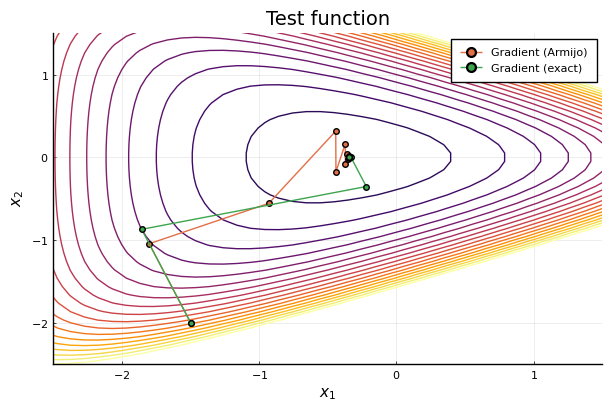

In [22]:
# Using the same function and starting point from the tests
f(x) = exp(x[1] + 2*x[2] - 0.2) + exp(x[1] - 2*x[2] - 0.2) + exp(-x[1] - 0.2)
x = [-1.5, -2.0]  

# NOTE: Don't forget to set the keyword argument save_history parameter to 'true' implying that you want to receive the history of the iterations as an output
# Gather the history of the iterations for the Gradient method with Armijo rule as an inexact line search
(xga, kga) = gradient(f, x_start=x, exact_ls=false, save_history=true)

# Gather the history of the iterations for the Gradient method with Golden section rule as an exact line search
(xgg, kgg) = gradient(f, x_start=x, save_history=true)

# Defining the interval for the x1(x) and x2(y) axes
x = range(-5, 5, length = 100)
y = copy(x)

# Plotting the contour of the function 
contour(x,y, (x,y) -> f([x,y]), 
    title  = "Test function",
    levels = [0.0 + i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-2.5, 1.5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-2.5, 1.5)),
)

# Plotting the trajectory of the Gradient method with Armijo rule as an inexact line search
plot!(xga[:,1], xga[:,2], label = "Gradient (Armijo)", marker=:circle)

# Plotting the trajectory of the Gradient method with Golden section rule as an exact line search
plot!(xgg[:,1], xgg[:,2], label = "Gradient (exact)", marker=:circle)

# Saving the figure as .pdf file if needed
savefig("test_function_gradient.pdf")

# Space for answering Tasks (1) - (3)

The above has everything you need to answer the qeustion posed in Tasks (1)-(3). Be organised with your code, and comment well what you have implemented, so I can undersand what you are trying to achieve. Use the cells below to generate any comparisons and or plots you might want to include in your report. Make sure your arguments are supported by data and analysses obtained from these. And, if you need help with anything, ask on the Zulip chat. 

**Note:** feel free to add more cells per section, but keep your code organised according to the section headers.
#' 
## Code for Task 1

In [8]:
# Add the code you generate for task 1 here or in any additional cells before the header for the next task.

# Function for the analysis 
f_1(x) = 2*(0.5*x[1]^2 + 4*x[2]^2) - 0.5*x[1]*x[2]

# Starting point for f_1
xs1 = [-10.0, 10.0] 

2-element Vector{Float64}:
 -10.0
  10.0

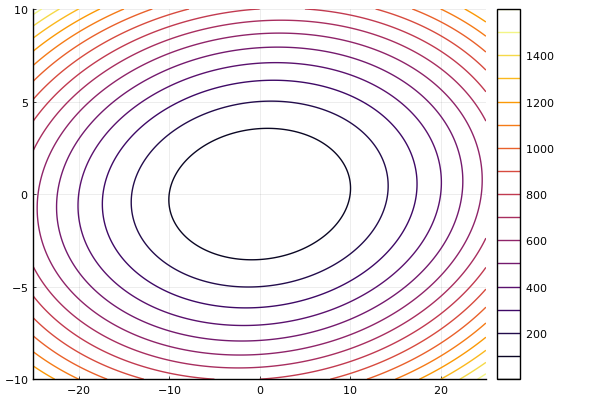

In [9]:
# Contour plot
n = 1000
#lb = -15; ub = 15
xran1 = LinRange(-25, 25, n)
yran1 = LinRange(-10, 10, n)

# Function fot the analysis 
f_1plot(x, y) = 2*(0.5*x^2 + 4*y^2) - 0.5*x*y

zran1 = [f_1plot(xran1[i], yran1[j]) for j=1:n, i=1:n]

Plots.plot(Plots.contour(xran1, yran1, zran1))

In [10]:
# Gradient with exact line (BISECTION) search method
println("Gradient with exact line (BISECTION) search method:")
(x_ge, k_ge) = gradient(f_1, x_start = xs1, exact_ls = true, save_history = true)

println("Optimal solution: $(x_ge[end,:])")
println("Optimal value: $(f_1(x_ge[end,:]))")
println("Number of iterations: $(k_ge)")

Gradient with exact line (BISECTION) search method:
Optimal solution: [-0.00026220430706841495, 3.5697357772918015e-6]
Optimal value: 6.932104280133612e-8
Number of iterations: 25


In [11]:
# Heavy ball with exact line (BISECTION) search method
println("Heavy ball with exact line (BISECTION) search method:")
(x_he, k_he) = heavy_ball(f_1, x_start = xs1, exact_ls = true, save_history = true)

println("Optimal solution: $(x_he[end,:])")
println("Optimal value: $(f_1(x_he[end,:]))")
println("Number of iterations: $(k_he)")

Heavy ball with exact line (BISECTION) search method:
Optimal solution: [-0.0002066076761703309, 3.391765015085788e-5]
Optimal value: 5.539381122596575e-8
Number of iterations: 16


In [12]:
# Gradient with inexact (ARMIJO) line search method
println("Gradient with inexact (ARMIJO) line search method:")
(x_gi, k_gi) = gradient(f_1, x_start = xs1, exact_ls = false, save_history = true)

println("Optimal solution: $(x_gi[end,:])")
println("Optimal value: $(f_1(x_gi[end,:]))")
println("Number of iterations: $(k_gi)")

Gradient with inexact (ARMIJO) line search method:
Optimal solution: [-0.00010360415318123536, -5.640575981320851e-5]
Optimal value: 3.326476298724801e-8
Number of iterations: 50


In [13]:
# Heavy ball with inexact line (ARMIJO) search method
println("Heavy ball with inexact line (ARMIJO) search method:")
(x_hi, k_hi) = heavy_ball(f_1, x_start = xs1, exact_ls = false, save_history = true)

println("Optimal solution: $(x_hi[end,:])")
println("Optimal value: $(f_1(x_hi[end,:]))")
println("Number of iterations: $(k_hi)")

Heavy ball with inexact line (ARMIJO) search method:
Optimal solution: [-1.0231684436700003e-5, -6.236497567146043e-5]
Optimal value: 3.090075951494059e-8
Number of iterations: 37


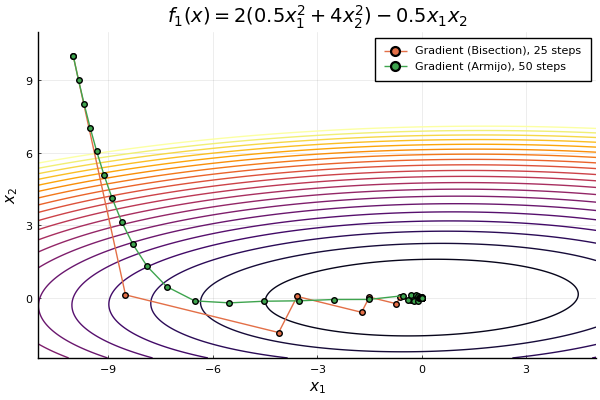

In [24]:
# Plot trajectories.
x = range(-11, 5, length = 500)
y = range(-2.5, 11, length = 500)
# Plot function contours.
contour(x,y, (x,y) -> f_1([x,y]),
    title  = L"$f_1(x) = 2(0.5x_1^2 + 4x_2^2) - 0.5x_1x_2$",
    levels = [0.0 + 20*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,20*20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-11, 5)),        # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-2.5, 11)),
)

# Gradient method with exact line (Bisection) search.
plot!(x_ge[:,1], x_ge[:,2], label = "Gradient (Bisection), $(k_ge) steps", marker=:circle, legend=:topright)

# Gradient method with inexact line (Armijo) search.
plot!(x_gi[:,1], x_gi[:,2], label = "Gradient (Armijo), $(k_gi) steps", marker=:circle)

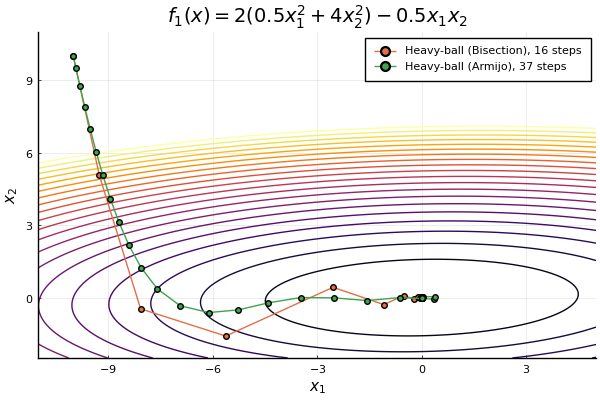

In [25]:
# Plot trajectories.
x = range(-11, 5, length = 500)
y = range(-2.5, 11, length = 500)
# Plot function contours.
contour(x,y, (x,y) -> f_1([x,y]),
    title  = L"$f_1(x) = 2(0.5x_1^2 + 4x_2^2) - 0.5x_1x_2$",
    levels = [0.0 + 20*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,20*20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-11, 5)),        # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-2.5, 11)),
)

# Heavy-ball method with exact line (Bisection) search.
plot!(x_he[:,1], x_he[:,2], label = "Heavy-ball (Bisection), $(k_he) steps", marker=:circle)

# Heavy-ball method with inexact line (Armijo) search.
plot!(x_hi[:,1], x_hi[:,2], label = "Heavy-ball (Armijo), $(k_hi) steps", marker=:circle)

In [35]:
# benchmark gradient method with exact line search
print("Gradient method with exact (Bisection) line search:")
@btime gradient(f_1, x_start = xs1, exact_ls = true)    

@benchmark gradient(f_1, x_start = xs1, exact_ls = true)    

Gradient method with exact line search:  463.905 μs (3686 allocations: 209.45 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  373.969 μs …  26.673 ms  ┊ GC (min … max): 0.00% … 98.19%
 Time  (median):     411.321 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   484.810 μs ± 645.379 μs  ┊ GC (mean ± σ):  6.97% ±  5.35%

  ▃▄█▇▇▆▅▄▄▄▃▂▂▅▄▄▃▂▁▁          ▁▂▁                ▁            ▂
  ████████████████████████▆▆▅▆▆▆█████▇▇▆▅███▆▆▅▇▇▆████▇█▆▆▄▅▄▅▅ █
  374 μs        Histogram: log(frequency) by time        818 μs <

 Memory estimate: 209.45 KiB, allocs estimate: 3686.

In [37]:
# benchmark heavy_ball method with exact line search
print("Heavy ball method with exact (Bisection) line search:")
@btime heavy_ball(f_1, x_start = xs1, exact_ls = true)

@benchmark heavy_ball(f_1, x_start = xs1, exact_ls = true)    

Heavy ball method with exact line search:  336.012 μs (2861 allocations: 151.33 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  261.445 μs …  29.409 ms  ┊ GC (min … max): 0.00% … 97.97%
 Time  (median):     283.066 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   331.229 μs ± 631.565 μs  ┊ GC (mean ± σ):  8.47% ±  4.63%

  ▅▆█▇▆▅▅▄▃▃▃▃▃▃▂▂▁                  ▁                          ▂
  ███████████████████▇▇▇▆▄▄▄▄▄▃▃▂▅▇▆██▇█▇▆█▇▆▄▅▅▅▄▆▅▆▄▅▅▄▃▃▄▅▅▅ █
  261 μs        Histogram: log(frequency) by time        621 μs <

 Memory estimate: 151.33 KiB, allocs estimate: 2861.

In [36]:
# benchmark gradient method with inexact line search
print("Gradient method with inexact (Armijo) line search:")
@btime gradient(f_1, x_start = xs1, exact_ls = false) 

@benchmark gradient(f_1, x_start = xs1, exact_ls = false)    

Gradient method with Armijo line search:  289.013 μs (4079 allocations: 190.28 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  231.274 μs …  14.956 ms  ┊ GC (min … max):  0.00% … 97.48%
 Time  (median):     258.539 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   310.864 μs ± 645.632 μs  ┊ GC (mean ± σ):  10.95% ±  5.21%

  ██▆▃▂     ▂                                                    
  █████▇▆▅▄▇█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  231 μs           Histogram: frequency by time          623 μs <

 Memory estimate: 190.28 KiB, allocs estimate: 4079.

In [38]:
# benchmark heavy_ball method with inexact line search
print("Heavy ball method with inexact (Armijo) line search:")
@btime heavy_ball(f_1, x_start = xs1, exact_ls = false)

@benchmark heavy_ball(f_1, x_start = xs1, exact_ls = false)   

Heavy ball method with Armijo line search:  213.469 μs (2637 allocations: 121.38 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  206.593 μs …  14.637 ms  ┊ GC (min … max): 0.00% … 97.76%
 Time  (median):     212.981 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   244.739 μs ± 550.440 μs  ┊ GC (mean ± σ):  9.70% ±  4.24%

  ▄██▇▆▅▅▄▄▄▃▃▂▂▂▁▁▁▁                        ▁▁▁                ▂
  ████████████████████▇▇▇▇▇▇▆▆▅▅▆▆▅▄▆▆▅▆▅▆▇█████▇▅▅▅▅▅▃▄▃▃▁▁▁▁▃ █
  207 μs        Histogram: log(frequency) by time        334 μs <

 Memory estimate: 121.38 KiB, allocs estimate: 2637.

## Code for Task 2

In [27]:
# Add the code you generate for task 2 here or in any additional cells before the header for the next task.

# Function for the analysis 
f_2(x) = exp(x[1] + 2*x[2] - 0.1) + exp(x[1] - 2*x[2] - 0.1) + exp(-x[1] - 0.2) 

# Starting point for f_2
xs2 = [-2.5, -3.5]

2-element Vector{Float64}:
 -2.5
 -3.5

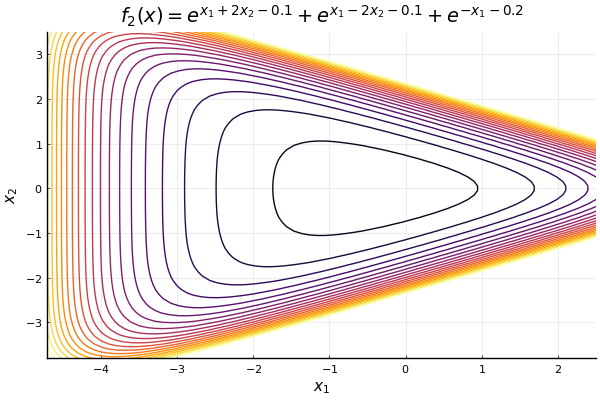

In [28]:
# Contour plot

# Function fot the analysis 
f_2plot(x, y) = exp(x + 2*y - 0.1) + exp(x - 2*y - 0.1) + exp(-x - 0.2) 

# Plot trajectories..
x = range(-5, 5, length = 100)
y = copy(x)
# Plot function contours.
contour(x,y, (x,y) -> f_2([x,y]),
    title  = L"$f_2(x) = e^{x_1+2x_2-0.1} + e^{x_1-2x_2-0.1} + e^{-x_1-0.2}$",
    levels = [0.0 + 5*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,5*20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-4.7, 2.5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-3.8, 3.5)),
)

In [30]:
# Newton with exact line (BISECTION) search method
println("Newton with exact line (BISECTION) search method:")
(x_ne, k_ne) = newton(f_2, x_start = xs2, exact_ls = true, save_history = true)

println("Optimal solution: $(x_ne[end,:])")
println("Optimal value: $(f_2(x_ne[end,:]))")
println("Number of iterations: $(k_ne)")

Newton with exact line (BISECTION) search method:
Optimal solution: [-0.3966225735092932, -0.0001174868492799545]
Optimal value: 2.4344498235280483
Number of iterations: 4


In [31]:
# BFGS with exact line (BISECTION) search method
println("BFGS with exact line (BISECTION) search method:")
(x_be, k_be) = bfgs(f_2, x_start = xs2, exact_ls = true, save_history = true)

println("Optimal solution: $(x_be[end,:])")
println("Optimal value: $(f_2(x_be[end,:]))")
println("Number of iterations: $(k_be)")

BFGS with exact line (BISECTION) search method:
Optimal solution: [-0.39657919541236436, -6.100139196680532e-5]
Optimal value: 2.4344497961032303
Number of iterations: 6


In [32]:
# Newton with inexact (ARMIJO) line search method
println("Newton with inexact (ARMIJO) line search method:")
(x_ni, k_ni) = newton(f_2, x_start = xs2, exact_ls = false, save_history = true)

println("Optimal solution: $(x_ni[end,:])")
println("Optimal value: $(f_2(x_ni[end,:]))")
println("Number of iterations: $(k_ni)")

Newton with inexact (ARMIJO) line search method:
Optimal solution: [-0.39641998997094596, -0.00014349831877286112]
Optimal value: 2.4344498658614167
Number of iterations: 7


In [33]:
# BFGS with inexact line (ARMIJO) search method
println("BFGS with inexact line (ARMIJO) search method:")
(x_bi, k_bi) = bfgs(f_2, x_start = xs2, exact_ls = false, save_history = true)

println("Optimal solution: $(x_bi[end,:])")
println("Optimal value: $(f_2(x_bi[end,:]))")
println("Number of iterations: $(k_bi)")

BFGS with inexact line (ARMIJO) search method:
Optimal solution: [-0.3963963385532059, -4.4717518233131645e-6]
Optimal value: 2.4344498252977114
Number of iterations: 14


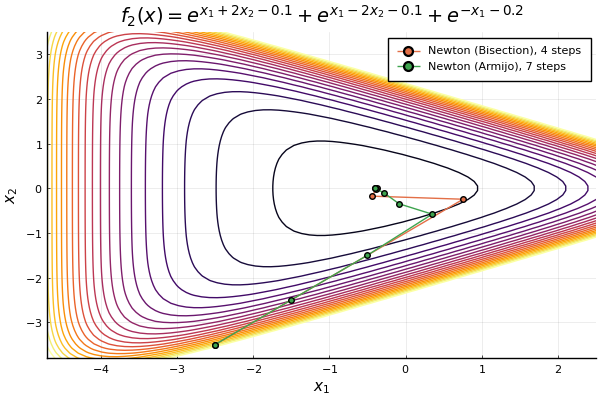

In [34]:
# Plot trajectories..
x = range(-5, 5, length = 100)
y = copy(x)
# Plot function contours.
contour(x,y, (x,y) -> f_2([x,y]),
    title  = L"$f_2(x) = e^{x_1+2x_2-0.1} + e^{x_1-2x_2-0.1} + e^{-x_1-0.2}$",
    levels = [0.0 + 5*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,5*20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-4.7, 2.5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-3.8, 3.5)),
)

# Newton's method with exact line (Bisection) search.
plot!(x_ne[:,1], x_ne[:,2], label = "Newton (Bisection), $(k_ne) steps", marker=:circle, legend=:topright)

# Newton's method with inexact line (Armijo) search.
plot!(x_ni[:,1], x_ni[:,2], label = "Newton (Armijo), $(k_ni) steps", marker=:circle)

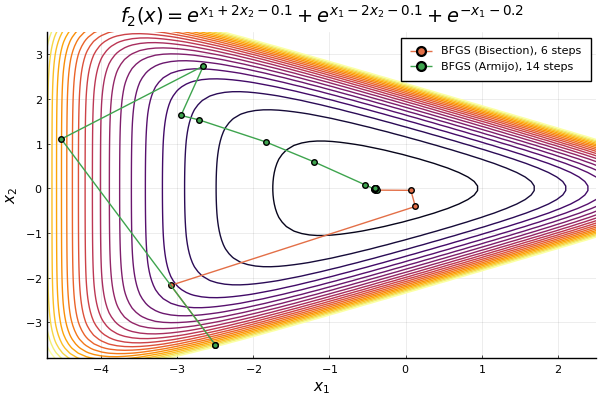

In [35]:
# Plot trajectories..
x = range(-5, 5, length = 100)
y = copy(x)
# Plot function contours.
contour(x,y, (x,y) -> f_2([x,y]),
    title  = L"$f_2(x) = e^{x_1+2x_2-0.1} + e^{x_1-2x_2-0.1} + e^{-x_1-0.2}$",
    levels = [0.0 + 5*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,5*20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-4.7, 2.5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-3.8, 3.5)),
)

# BFGS method with exact line (Bisection) search.
plot!(x_be[:,1], x_be[:,2], label = "BFGS (Bisection), $(k_be) steps", marker=:circle)

# BFGS method with inexact line (Armijo) search.
plot!(x_bi[:,1], x_bi[:,2], label = "BFGS (Armijo), $(k_bi) steps", marker=:circle)

In [62]:
# benchmark newton method with exact line search
print("Newton method with exact (Bisection) line search:")
@btime newton(f_2, x_start = xs2, exact_ls = true)    

@benchmark newton(f_2, x_start = xs2, exact_ls = true)

Newton method with exact (Bisection) line search:  105.429 μs (643 allocations: 39.34 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  105.733 μs …  29.048 ms  ┊ GC (min … max): 0.00% … 99.12%
 Time  (median):     133.212 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   144.224 μs ± 412.973 μs  ┊ GC (mean ± σ):  3.97% ±  1.40%

  ▅█▆▂▂▁ ▁▅▆▇▆▆▅▄▂▂▁▁      ▃▃        ▁▂▁▁▁                      ▂
  ██████████████████████▇█████▆▆▆▆▆▇████████▇▇▇▇▆▆▆▇▆▆▇█▇▇▇▆▆▇▆ █
  106 μs        Histogram: log(frequency) by time        271 μs <

 Memory estimate: 39.34 KiB, allocs estimate: 643.

In [50]:
# benchmark bfgs method with exact line search
print("BFGS method with exact (Bisection) line search:")
@btime bfgs(f_2, x_start = xs2, exact_ls = true)

@benchmark bfgs(f_2, x_start = xs2, exact_ls = true)    

BFGS method with exact (Bisection) line search:  186.870 μs (1027 allocations: 60.56 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  188.070 μs …  42.742 ms  ┊ GC (min … max): 0.00% … 99.19%
 Time  (median):     230.814 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   247.131 μs ± 623.037 μs  ┊ GC (mean ± σ):  4.85% ±  1.98%

  ▇█▄▃▃▃▂▆▇▇▆▅▄▃▂▁ ▁      ▂▁                                    ▂
  ██████████████████████▇▇██▇▆▆▅▄▆▇██▇▄▅▄▄▅▄▄▅▆▆▆▇▆▆▄▅▃▅▄▅▅▇▇██ █
  188 μs        Histogram: log(frequency) by time        497 μs <

 Memory estimate: 60.56 KiB, allocs estimate: 1027.

In [51]:
# benchmark newton method with inexact line search
print("Newton method with inexact (Armijo) line search:")
@btime newton(f_2, x_start = xs2, exact_ls = false)    

@benchmark newton(f_2, x_start = xs2, exact_ls = false) 

Newton method with inexact (Armijo) line search:  65.925 μs (277 allocations: 20.70 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  66.023 μs …  27.854 ms  ┊ GC (min … max): 0.00% … 99.07%
 Time  (median):     76.993 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   87.067 μs ± 278.691 μs  ┊ GC (mean ± σ):  3.17% ±  0.99%

  ▁▅██▇▆▆▆▆▆▅▄▃▂▂▁          ▂▂▂▂▂▁▁▁                           ▂
  █████████████████▇▇▇▆▅▆▆██████████████▇▆▆▇▆▅▅▆▆▅▅▆▅▅▆▄▆▆▇▆▆▇ █
  66 μs         Histogram: log(frequency) by time       182 μs <

 Memory estimate: 20.70 KiB, allocs estimate: 277.

In [52]:
# benchmark bfgs method with inexact line search
print("BFGS method with inexact (Armijo) line search:")
@btime bfgs(f_2, x_start = xs2, exact_ls = false)

@benchmark bfgs(f_2, x_start = xs2, exact_ls = false)

BFGS method with inexact (Armijo) line search:  155.331 μs (813 allocations: 49.97 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  155.787 μs …  26.739 ms  ┊ GC (min … max): 0.00% … 98.80%
 Time  (median):     175.563 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   193.408 μs ± 454.875 μs  ┊ GC (mean ± σ):  4.04% ±  1.71%

   █▁                                                            
  ▅██▅▄▃▄▄▃▃▃▅▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂ ▃
  156 μs           Histogram: frequency by time          364 μs <

 Memory estimate: 49.97 KiB, allocs estimate: 813.

## Code for Task 3

In [36]:
# Add the code you generate for task 3 here or in any additional cells before the header for the next task.

# Function for the analysis 
f_3(x) = (x[1]^2 + x[2] - 10)^2 + (x[1] + x[2]^2 - 15)^2

# Starting point for f_2
xs3 = [-0.5, -2]

2-element Vector{Float64}:
 -0.5
 -2.0

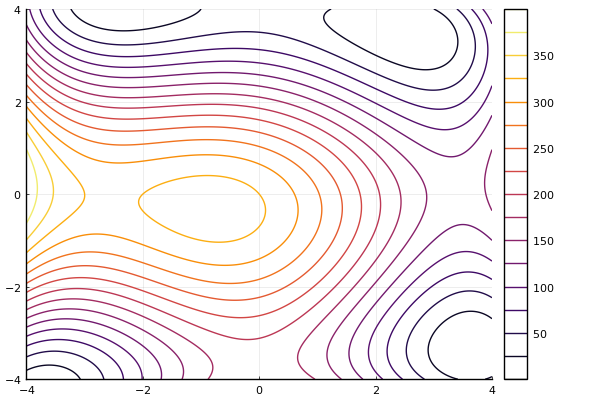

In [37]:
# Contour plot
n = 1000
#lb = -1.5; ub = 1
xran3 = LinRange(-4, 4, n)
yran3 = LinRange(-4, 4, n)

# Function fot the analysis 
f_3plot(x, y) = (x^2 + y - 10)^2 + (x + y^2 - 15)^2

zran3 = [f_3plot(xran3[i], yran3[j]) for j=1:n, i=1:n]

Plots.plot(Plots.contour(xran3, yran3, zran3))

In [38]:
# Gradient with exact line (BISECTION) search method
println("Gradient with exact line (BISECTION) search method:")
(x_ge, k_ge) = gradient(f_3, x_start = xs3, exact_ls = true, save_history = true)

println("Optimal solution: $(x_ge[end,:])")
println("Optimal value: $(f_3(x_ge[end,:]))")
println("Number of iterations: $(k_ge)")

Gradient with exact line (BISECTION) search method:
Optimal solution: [-3.7860627328877285, -4.334288930162623]
Optimal value: 3.257205918793565e-10
Number of iterations: 11


In [39]:
# Heavy ball with exact line (BISECTION) search method
println("Heavy ball with exact line (BISECTION) search method:")
(x_he, k_he) = heavy_ball(f_3, x_start = xs3, exact_ls = true, save_history = true)

println("Optimal solution: $(x_he[end,:])")
println("Optimal value: $(f_3(x_he[end,:]))")
println("Number of iterations: $(k_he)")

Heavy ball with exact line (BISECTION) search method:
Optimal solution: [-3.7860625599472146, -4.334286877820582]
Optimal value: 6.876685668724081e-10
Number of iterations: 18


In [40]:
# Newton with exact line (BISECTION) search method
println("Newton with exact line (BISECTION) search method:")
(x_ne, k_ne) = newton(f_3, x_start = xs3, exact_ls = true, save_history = true)

println("Optimal solution: $(x_ne[end,:])")
println("Optimal value: $(f_3(x_ne[end,:]))")
println("Number of iterations: $(k_ne)")

Newton with exact line (BISECTION) search method:
Optimal solution: [-2.4139172013746615, 4.172998684950033]
Optimal value: 2.628086101959422e-11
Number of iterations: 3


In [41]:
# BFGS with exact line (BISECTION) search method
println("BFGS with exact line (BISECTION) search method:")
(x_be, k_be) = bfgs(f_3, x_start = xs3, exact_ls = true, save_history = true)

println("Optimal solution: $(x_be[end,:])")
println("Optimal value: $(f_3(x_be[end,:]))")
println("Number of iterations: $(k_be)")

BFGS with exact line (BISECTION) search method:
Optimal solution: [-3.7860651723273975, -4.334289465466008]
Optimal value: 5.625874276159953e-16
Number of iterations: 6


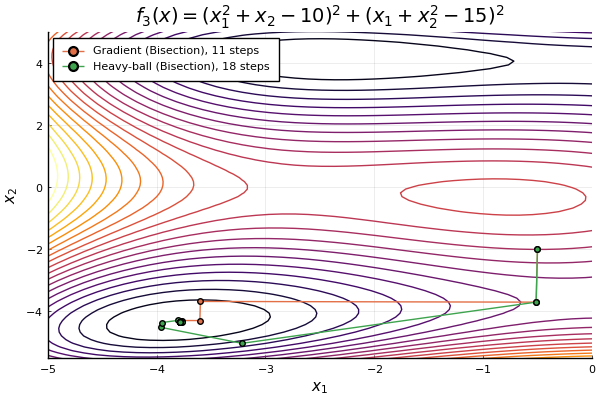

In [42]:
# Plot trajectories.
x = range(-6, 6, length = 100)
y = copy(x)
# Plot function contours.
contour(x,y, (x,y) -> f_3([x,y]),
    title  = L"$f_3(x) = (x_1^2+x_2-10)^2 + (x_1+x_2^2-15)^2$",
    levels = [0.0 + 30*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,30*20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-5, 0*5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-5.5, 5)),
)

# Gradient method with exact (Bisection) line serach.
plot!(x_ge[:,1], x_ge[:,2], label = "Gradient (Bisection), $(k_ge) steps", marker=:circle, legend=:topleft)

# Heavy-ball method with exact (Bisection) line serach.
plot!(x_he[:,1], x_he[:,2], label = "Heavy-ball (Bisection), $(k_he) steps", marker=:circle)

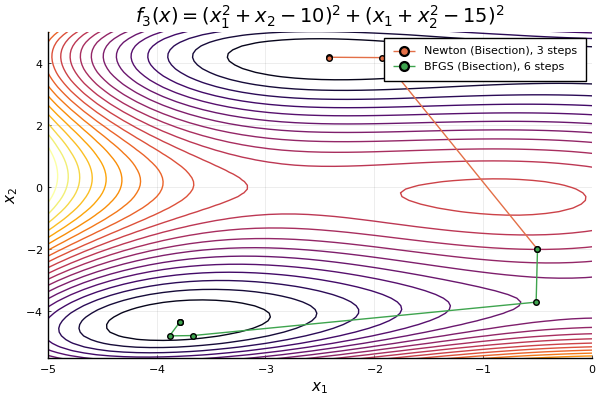

In [43]:
# Plot trajectories.
x = range(-6, 6, length = 100)
y = copy(x)
# Plot function contours.
contour(x,y, (x,y) -> f_3([x,y]),
    title  = L"$f_3(x) = (x_1^2+x_2-10)^2 + (x_1+x_2^2-15)^2$",
    levels = [0.0 + 30*i for i = 1:20],  # which level curves to show 
    cbar = false,     
    clims = (0,30*20),                   # adjust the coloring limits
    xaxis = (L"$x_1$", (-5, 0*5)),  # the L at the front let us use LaTeX axis labels; the parethesis give the visual range 
    yaxis = (L"$x_2$", (-5.5, 5)),
)

# Newton's method with exact (Bisection) line serach.
plot!(x_ne[:,1], x_ne[:,2], label = "Newton (Bisection), $(k_ne) steps", marker=:circle)

# BFGS method with exact (Bisection) line serach.
plot!(x_be[:,1], x_be[:,2], label = "BFGS (Bisection), $(k_be) steps", marker=:circle)

In [90]:
# benchmark gradient method with exact line search
print("Gradient method with exact (Bisection) line search:")
@btime gradient(f_3, x_start = xs3, exact_ls = true)    

@benchmark gradient(f_3, x_start = xs3, exact_ls = true)    

Gradient method with exact (Bisection) line search:  175.460 μs (1628 allocations: 92.42 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  177.995 μs …  48.910 ms  ┊ GC (min … max): 0.00% … 99.40%
 Time  (median):     239.921 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   277.789 μs ± 836.413 μs  ┊ GC (mean ± σ):  7.17% ±  2.42%

   ▁       ▅█▅▃        ▂▇                                        
  ▁█▆▄▂▃▄▅▂█████▆▄▂▂▂▂▃███▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁ ▂
  178 μs           Histogram: frequency by time          474 μs <

 Memory estimate: 92.42 KiB, allocs estimate: 1628.

In [91]:
# benchmark heavy_ball method with exact (Bisection) line search
print("Heavy ball method with exact (Bisection) line search:")
@btime heavy_ball(f_3, x_start = xs3, exact_ls = true)

@benchmark heavy_ball(f_3, x_start = xs3, exact_ls = true)  

Heavy ball method with exact line search:  354.940 μs (3217 allocations: 170.17 KiB)


BenchmarkTools.Trial: 9408 samples with 1 evaluation.
 Range (min … max):  355.505 μs … 76.754 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     462.100 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   521.658 μs ±  1.645 ms  ┊ GC (mean ± σ):  8.46% ± 3.21%

  ▁█▆▅▃▃▄▃▄▄▄▃▅█▇▅▄▄▃▃▂▂▂▂      ▁▃▁ ▁          ▁▁▁▁            ▂
  █████████████████████████▇▇▇▇▆██████▇▇▅▆▆▅▅▆████████▇▇▆▇▆▇▇▇ █
  356 μs        Histogram: log(frequency) by time       839 μs <

 Memory estimate: 170.17 KiB, allocs estimate: 3217.

In [92]:
# benchmark newton method with exact line search
print("Newton method with exact (Bisection) line search:")
@btime newton(f_3, x_start = xs3, exact_ls = true)    

@benchmark newton(f_3, x_start = xs3, exact_ls = true)    

Newton method with exact line search:  75.915 μs (485 allocations: 29.62 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   76.821 μs …  60.162 ms  ┊ GC (min … max): 0.00% … 99.43%
 Time  (median):      98.877 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   121.761 μs ± 746.360 μs  ┊ GC (mean ± σ):  8.48% ±  1.41%

   ▃     ▂█▆▄▁                                                   
  ▃█▆▂▁▂▄█████▆▅▄▃▃▃▃▃▂▂▂▁▂▁▁▁▁▂▂▂▁▂▃▃▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  76.8 μs          Histogram: frequency by time          205 μs <

 Memory estimate: 29.62 KiB, allocs estimate: 485.

In [93]:
# benchmark bfgs method with exact line search
print("BFGS method with exact (Bisection) line search:")
@btime bfgs(f_3, x_start = xs3, exact_ls = true)

@benchmark bfgs(f_3, x_start = xs3, exact_ls = true)    

BFGS method with exact line search:  152.850 μs (1027 allocations: 60.56 KiB)


BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  153.447 μs …  56.834 ms  ┊ GC (min … max): 0.00% … 99.46%
 Time  (median):     192.353 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   199.557 μs ± 755.601 μs  ┊ GC (mean ± σ):  7.11% ±  1.98%

     ██▂                      ▂▄▅▅▃▂                             
  ▁▃████▅▂▁▁▁▁▁▁▁▂▄▆▅▃▂▁▂▂▂▃▄▇██████▇▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  153 μs           Histogram: frequency by time          238 μs <

 Memory estimate: 60.56 KiB, allocs estimate: 1027.

## Performance profiles

The functions below calculate generates the data and calculate everything that is needed to generate the performance profiles. Notice how the functions are generated. These are quadratic functions for which the matrix $A$ (its Hessian) is randomly generated in a way that the main diagonal is artificially inflated to provoke larger eigenvalues (the larger the values $\delta$, the smaller will be the relative difference between the eigenvalues.)

In [94]:
using Random # for generating the instances

## Generate a random symmetric positive definite matrix
## A ∈ ℜⁿˣⁿ and a random vector b ∈ ℜⁿ
function generate_problem_data(n::Int, δ::Float64)
    A = randn(n,n)                # Create random matrix
    A = (A + A')/2                # Make A symmetric
    if isposdef(A) == false       # Check if A is PD
        λᵢ = eigmin(A)            # Minimum eigenvalue
        A = A + (abs(λᵢ) + δ)*I   # Add λᵢ + δ to diagonal elements
    end
    @assert(isposdef(A))          # Final PD test
    b = randn(n)                  # Create random vector b
    return (A,b)                  # Resulting matrix A is PD
end


# Generate k test instances of dimension n
function generate_instances(k::Int, n::Int, δ::StepRangeLen)
    A = Dict{Int,Matrix{Float64}}()   # Store matrices A
    b = Dict{Int,Vector{Float64}}()   # Store vectors  b
    for i = 1:k
        ## NOTE: Change δ between, e.g., δ ∈ [0.01, 1] to get different
        ##       condition numbers for matrix A
        (A[i], b[i]) = generate_problem_data(n, δ[i])
    end
    return (A, b)
end

# Experiment parameters
Random.seed!(2021)                          # Control randomness
k = 50                                      # Number of instances to generate
n = 100                                     # Dimension of PD matrix A ∈ ℜⁿˣⁿ
δ1 = range(0.05, length = k, step = 0.05)   # Moderate condition numbers for matrices A
δ2 = range(0.005, length = k, step = 0.005) # Larger condition numbers for matrices A

# Resetting the parameters for the performance profiles
# !Do not change these parameters hereafrer                                 
N   = 10000                      # Number of iterations
x₀  = ones(n)                    # Starting point
ns  = 8                          # Number of solvers (methods) to compare
np  = k                          # Number of problems to solve

## Generate problem data with δ1 and δ2
(A1, b1) = generate_instances(k, n, δ1)
(A2, b2) = generate_instances(k, n, δ2)

## Function to minimize with two different data
f1(x,i) = (1/2)*dot(x, A1[i]*x) - dot(b1[i], x)
f2(x,i) = (1/2)*dot(x, A2[i]*x) - dot(b2[i], x)

## Optimal solution costs
fopt = zeros(k,2)
for i = 1:k
    x1 = A1[i]\b1[i]
    x2 = A2[i]\b2[i]
    fopt[i,1] = f1(x1,i)
    fopt[i,2] = f2(x2,i)
end

###### Preallocate data #######

# Solution costs
fval_gradient_exact   = zeros(k, 2)
fval_gradient_armijo   = zeros(k, 2)
fval_heavy_ball_exact  = zeros(k, 2)
fval_heavy_ball_armijo = zeros(k, 2)
fval_newton_exact      = zeros(k, 2)
fval_newton_armijo     = zeros(k, 2)
fval_bfgs_exact        = zeros(k, 2)
fval_bfgs_armijo       = zeros(k, 2)

# Solution times
time_gradient_exact    = zeros(k, 2)
time_gradient_armijo   = zeros(k, 2)
time_heavy_ball_exact  = zeros(k, 2)
time_heavy_ball_armijo = zeros(k, 2)
time_newton_exact      = zeros(k, 2)
time_newton_armijo     = zeros(k, 2)
time_bfgs_exact        = zeros(k, 2)
time_bfgs_armijo       = zeros(k, 2)

# Number of iterations
iter_gradient_exact    = zeros(Int, k, 2)
iter_gradient_armijo   = zeros(Int, k, 2)
iter_heavy_ball_exact  = zeros(Int, k, 2)
iter_heavy_ball_armijo = zeros(Int, k, 2)
iter_newton_exact      = zeros(Int, k, 2)
iter_newton_armijo     = zeros(Int, k, 2)
iter_bfgs_exact        = zeros(Int, k, 2)
iter_bfgs_armijo       = zeros(Int, k, 2)

# Solution status
stat_gradient_exact    = fill(false, k, 2)
stat_gradient_armijo   = fill(false, k, 2)
stat_heavy_ball_exact  = fill(false, k, 2)
stat_heavy_ball_armijo = fill(false, k, 2)
stat_newton_exact      = fill(false, k, 2)
stat_newton_armijo     = fill(false, k, 2)
stat_bfgs_exact        = fill(false, k, 2)
stat_bfgs_armijo       = fill(false, k, 2)

computing_time = zeros(np,ns,2);  # Computing times for each problem/method.

## Generate the plot profiles

The cell below perform the calculations to generate the data for comparing the methods using performance profiles. You don't have to change anything in them, but it might be worth a peak. 

**Be careful**: the cell below will run the eight variants of the implemented methods for 50 instances of each function. This takes a considerable while, so make sure you only run it when you are 100% sure your previous implementations are correct. Allocate about 30min-1h for these results to be available. The progress will be printed as it runs, so you can estimate how far it is from termination.

In [95]:
tini = time()
## Go through all instances for both sets of data
for j = 1:2 
    for i = 1:k
  
        println("Solving problem $(j)/2, run $(i)/$(k). Elapsed time: $(round(time() - tini, digits=2))")        
        # Function to minimize
        g1(x) = f1(x,i)
        g2(x) = f2(x,i)
    
        # Gradient with exact line search
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = gradient(g1, x_start=x₀, max_steps=N)
        else
            (fvalue, numiter) = gradient(g2, x_start=x₀, max_steps=N)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_gradient_exact[i, j] = fvalue       # Objective value
        time_gradient_exact[i, j] = soltime      # Solution time
        iter_gradient_exact[i, j] = numiter      # Iteration count
        stat_gradient_exact[i, j] = status       # Solution status
        # Set solution time accordingly
        status == true ? computing_time[i, 1, j] = soltime : computing_time[i, 1, j] = Inf    
    
        # Gradient + Armijo
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = gradient(g1, x_start=x₀, max_steps=N, exact_ls=false)
        else
            (fvalue, numiter) = gradient(g2, x_start=x₀, max_steps=N, exact_ls=false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_gradient_armijo[i, j] = fvalue       # Objective value
        time_gradient_armijo[i, j] = soltime      # Solution time
        iter_gradient_armijo[i, j] = numiter      # Iteration count
        stat_gradient_armijo[i, j] = status       # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 2, j] = soltime : computing_time[i, 2, j] = Inf  
    
        ## Heavy ball + Golden
        starttime = time()                      # Start timer
        if j == 1
            (fvalue, numiter) = heavy_ball(g1, x_start=x₀, max_steps=N)
        else
            (fvalue, numiter) = heavy_ball(g2, x_start=x₀, max_steps=N)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_heavy_ball_exact[i, j] = fvalue     # Objective value
        time_heavy_ball_exact[i, j] = soltime    # Solution time
        iter_heavy_ball_exact[i, j] = numiter    # Iteration count
        stat_heavy_ball_exact[i, j] = status     # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 3, j] = soltime : computing_time[i, 3, j] = Inf  
    
        ## Heavy ball + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = heavy_ball(g1, x_start=x₀, max_steps=N, exact_ls=false)
        else
            (fvalue, numiter) = heavy_ball(g2, x_start=x₀, max_steps=N, exact_ls=false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_heavy_ball_armijo[i, j] = fvalue     # Objective value
        time_heavy_ball_armijo[i, j] = soltime    # Solution time
        iter_heavy_ball_armijo[i, j] = numiter    # Iteration count
        stat_heavy_ball_armijo[i, j] = status     # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 4, j] = soltime : computing_time[i, 4, j] = Inf  

        ## Newton + Golden
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = newton(g1, x_start=x₀, max_steps=N)
        else
            (fvalue, numiter) = newton(g2, x_start=x₀, max_steps=N)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_newton_exact[i, j] = fvalue         # Objective value
        time_newton_exact[i, j] = soltime        # Solution time
        iter_newton_exact[i, j] = numiter        # Iteration count
        stat_newton_exact[i, j] = status         # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 5, j] = soltime : computing_time[i, 5, j] = Inf
    
        ## Newton + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = newton(g1, x_start=x₀, max_steps=N, exact_ls=false)
        else
            (fvalue, numiter) = newton(g2, x_start=x₀, max_steps=N, exact_ls=false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_newton_armijo[i, j] = fvalue         # Objective value
        time_newton_armijo[i, j] = soltime        # Solution time
        iter_newton_armijo[i, j] = numiter        # Iteration count
        stat_newton_armijo[i, j] = status         # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 6, j] = soltime : computing_time[i, 6, j] = Inf    
        
        ## BFGS + Golden
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = bfgs(g1, x_start=x₀, max_steps=N)
        else
            (fvalue, numiter) = bfgs(g2, x_start=x₀, max_steps=N)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_bfgs_exact[i, j] = fvalue            # Objective value
        time_bfgs_exact[i, j] = soltime           # Solution time
        iter_bfgs_exact[i, j] = numiter           # Iteration count
        stat_bfgs_exact[i, j] = status            # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 7, j] = soltime : computing_time[i, 7, j] = Inf
    
        ## BFGS + Armijo
        starttime = time()                        # Start timer
        if j == 1
            (fvalue, numiter) = bfgs(g1, x_start=x₀, max_steps=N, exact_ls=false)
        else
            (fvalue, numiter) = bfgs(g2, x_start=x₀, max_steps=N, exact_ls=false)
        end
        soltime = time() - starttime              # Solution time
        status = abs(fvalue - fopt[i, j]) <= tol  # Check if solved or not
        fval_bfgs_armijo[i, j] = fvalue           # Objective value
        time_bfgs_armijo[i, j] = soltime          # Solution time
        iter_bfgs_armijo[i, j] = numiter          # Iteration count
        stat_bfgs_armijo[i, j] = status           # Solution status
        ## Set solution time accordingly
        status == true ? computing_time[i, 8, j] = soltime : computing_time[i, 8, j] = Inf
    end    
end
println("Total time: $(time() - tini)");

Solving problem 1/2, run 1/50. Elapsed time: 0.03
Solving problem 1/2, run 2/50. Elapsed time: 52.56
Solving problem 1/2, run 3/50. Elapsed time: 56.01
Solving problem 1/2, run 4/50. Elapsed time: 58.37
Solving problem 1/2, run 5/50. Elapsed time: 60.15
Solving problem 1/2, run 6/50. Elapsed time: 61.72
Solving problem 1/2, run 7/50. Elapsed time: 63.12
Solving problem 1/2, run 8/50. Elapsed time: 64.77
Solving problem 1/2, run 9/50. Elapsed time: 66.42
Solving problem 1/2, run 10/50. Elapsed time: 67.72
Solving problem 1/2, run 11/50. Elapsed time: 68.64
Solving problem 1/2, run 12/50. Elapsed time: 69.61
Solving problem 1/2, run 13/50. Elapsed time: 70.44
Solving problem 1/2, run 14/50. Elapsed time: 71.64
Solving problem 1/2, run 15/50. Elapsed time: 72.82
Solving problem 1/2, run 16/50. Elapsed time: 73.49
Solving problem 1/2, run 17/50. Elapsed time: 74.18
Solving problem 1/2, run 18/50. Elapsed time: 74.81
Solving problem 1/2, run 19/50. Elapsed time: 75.48
Solving problem 1/2, r

## Plot performance profiles

The code below generate the pdf files with the plots of each performance profile (one for the smaller condition numbers (condition 1) and another for the larger condition numbers (condition 2).

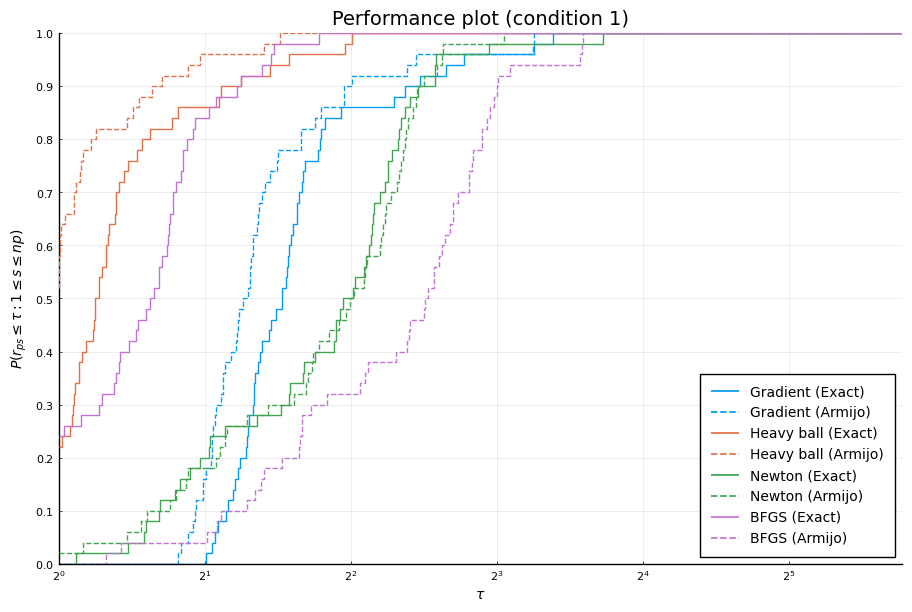

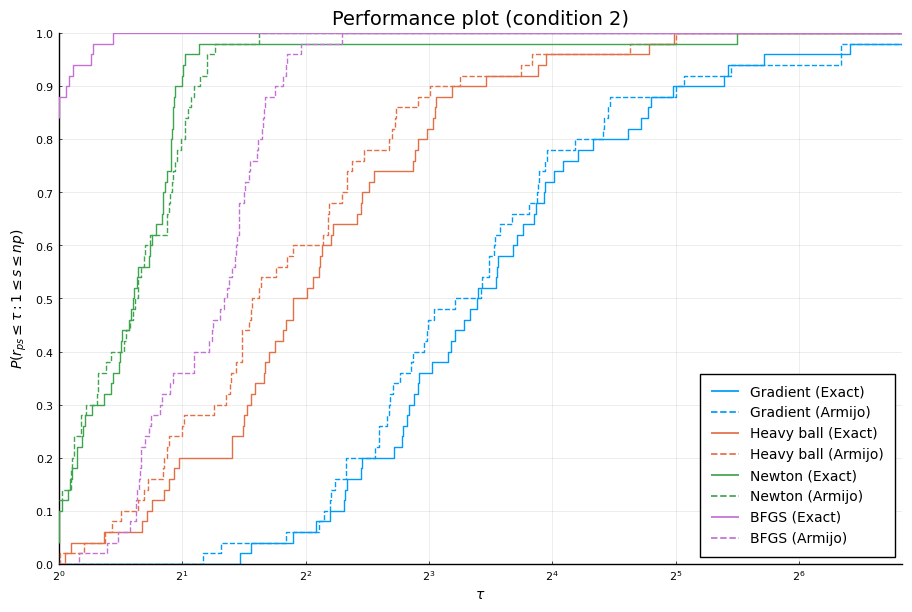

In [97]:
for j = 1:2
    ###### Plot performance profiles ######
    computing_time_min = minimum(computing_time[:, :, j], dims = 2)    # Minimum time for each instance
    performance_ratios = computing_time[:, :, j] ./ computing_time_min # Compute performance ratios

    τ = sort(unique(performance_ratios))  # Sort the performance ratios in increasing order
    τ[end] == Inf && pop!(τ)  # Remove the Inf element if it exists

    ns = 8                    # Number of solvers
    np = k                    # Number of problems

    ρS = Dict()               # Compute cumulative distribution functions
    for i = 1:ns              # for performance ratios
        ρS[i] = [sum(performance_ratios[:,i] .<= τi) / np for τi in τ]
    end

    # Plot performance profiles
    labels = ["Gradient (Exact)", "Gradient (Armijo)", "Heavy ball (Exact)", "Heavy ball (Armijo)",
              "Newton (Exact)", "Newton (Armijo)", "BFGS (Exact)", "BFGS (Armijo)"]

    styles = [:solid, :dash, :solid, :dash, :solid, :dash, :solid, :dash,]
    colors = [:1, :1, :2, :2, :3, :3, :4, :4]
    plot(xscale = :log2,  
         yscale = :none,
         xlim   = (1, maximum(τ)),
         ylim   = (0, 1),
         xlabel = L"$\tau$",
         ylabel = L"$P(r_{ps} \leq \tau : 1 \leq s \leq np)$",
         title  = "Performance plot (condition $(j))",
         xticks = [2^i for i = 0:9],
         yticks = 0.0:0.1:1.0,
         size   = (900,600),
         reuse  = false,
         tickfontsize   = 8,
         legendfontsize = 10,
         guidefontsize  = 10,
         grid = true,
         legend=:bottomright)
    for i = 1:ns
      plot!(τ, ρS[i], label = labels[i], seriestype = :steppre, linewidth = 1, line = styles[i], color = colors[i])
    end
    savefig("performance_plot_$(j).pdf")
end